# Before we start

Dowload the CIFAR10 dataset - we'll need it later. Run this in a terminal:

```bash
python -c "from torchvision.datasets import CIFAR10; CIFAR10('CIFAR10', download=True)"
```

In [1]:
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## The dataset

In [2]:
mnist = MNIST('MNIST', download=True)

In [3]:
images = np.array([np.array(x) for x, y in mnist])
labels = np.array([np.array(y) for x, y in mnist])

In [4]:
# 10-class classification task:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
x, y = images[0], labels[0]
x.shape, y

((28, 28), 5)

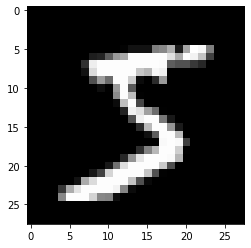

In [6]:
plt.imshow(x, cmap='gray')

## The architecture

In [7]:
import torch
from torch import nn
from torch.nn import functional

In [8]:
# change this to 'cpu' if you don't have an nvidia gpu
device = 'cuda'

In [9]:
images.shape

(60000, 28, 28)

In [10]:
# need to add the channels dim
images = images[:, None]

In [11]:
images.shape

(60000, 1, 28, 28)

In [12]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3), # 26 
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=3), # 24 
    nn.ReLU(),
    
    nn.MaxPool2d(2), # 12
    
    nn.Conv2d(8, 16, kernel_size=3), # 10
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3), # 8
    nn.ReLU(),
    
    nn.MaxPool2d(2), # 4 * 4 * 16
    
    nn.Flatten(),
    nn.Linear(256, 10),
).to(device)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training

In [14]:
def get_random_batch(size):
    indices = np.random.randint(0, len(images), size=size)
    
    xs, ys = images[indices], labels[indices]
    xs = torch.from_numpy(xs.astype('float32')).to(device)
    ys = torch.from_numpy(ys.astype('int64')).to(device)
    
    return xs, ys

In [15]:
for _ in range(2000):
    xs, ys = get_random_batch(10)
    
    predictions = model(xs)
    loss = functional.cross_entropy(predictions, ys)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    print(loss.item(), end='\r')

## Prediction

In [16]:
image_batch, label_batch = get_random_batch(1)

prediction = model(image_batch)

<BarContainer object of 10 artists>

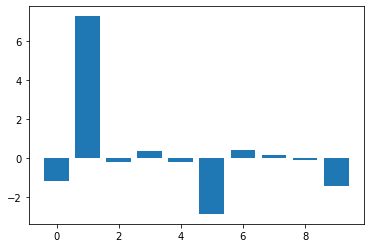

In [17]:
plt.bar(range(10), prediction[0].cpu().data)

In [18]:
prediction.argmax()

tensor(1, device='cuda:0')

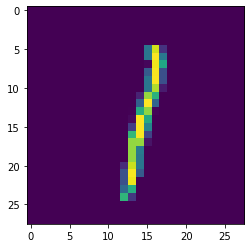

In [19]:
plt.imshow(image_batch[0, 0].cpu().data)

In [20]:
label_batch

tensor([1], device='cuda:0')

## Accuracy

In [21]:
test = MNIST('MNIST', train=False)

In [22]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

def eval_test(images, labels):
    results = []
    for image in tqdm(images):
        image = torch.from_numpy(image.astype('float32')).to(device)
        pred = model(image[None]).cpu().data.numpy()
        
        results.append(pred.argmax())
        
    return accuracy_score(labels, results)

In [23]:
eval_test(
    np.array([np.array(x) for x, y in test])[:, None],
    np.array([np.array(y) for x, y in test]),
)

0.9448

## CNNs as feature extractors

In [24]:
# strip off the last layer
feature_extractor = model[:-1]

In [25]:
feature_extractor

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
)

In [26]:
# you can use greater batch sizes for better visual results
image_batch, label_batch = get_random_batch(1000)

In [27]:
features = feature_extractor(image_batch)

In [28]:
features.shape

torch.Size([1000, 256])

In [29]:
features = features.cpu().data.numpy()
label_batch = label_batch.cpu().data.numpy()

In [30]:
from sklearn.manifold import TSNE

# embed the features to a 2D space
embeddings = TSNE().fit_transform(features)

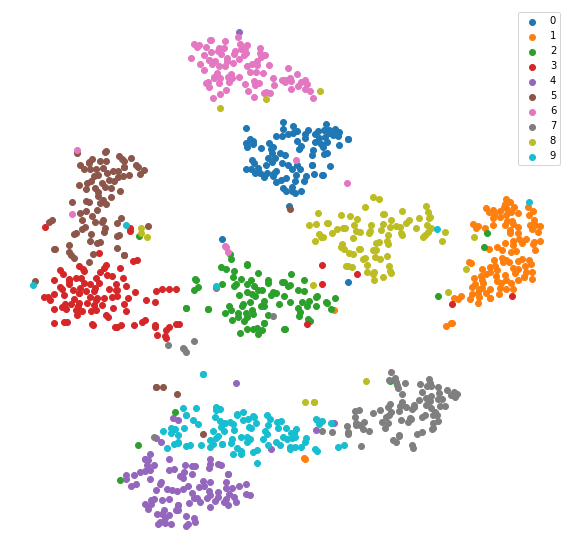

In [31]:
plt.figure(figsize=(10, 10))
plt.axis('off')

for label in range(10):
    plt.scatter(*embeddings[label_batch == label].T, label=str(label))
    
plt.legend()

# Something more challenging

In [32]:
from torchvision.datasets import CIFAR10

In [33]:
cifar = CIFAR10('CIFAR10', download=True)

Files already downloaded and verified


In [34]:
images = np.array([np.array(x) for x, y in cifar])
labels = np.array([np.array(y) for x, y in cifar])

In [35]:
# 10-class classification task:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
x, y = images[0], labels[0]
x.shape, y

((32, 32, 3), 6)

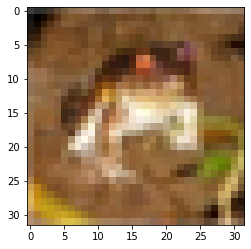

In [37]:
plt.imshow(x)

In [38]:
images.shape

(50000, 32, 32, 3)

In [39]:
images = np.moveaxis(images, -1, 1)

In [40]:
images.shape

(50000, 3, 32, 32)

## Model

In [41]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        x = x + self.conv(x)
        x = functional.relu(x)
        return x

In [42]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    ResBlock(16),
    
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    ResBlock(32),
    
    nn.MaxPool2d(2),
    
    
    nn.Conv2d(32, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    ResBlock(128),
    
    nn.MaxPool2d(2),
    
    nn.Flatten(),
    
    nn.Linear(4 * 4 * 128, 10),
).to(device)

In [43]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [44]:
# probably need a significantly larger number of iterations
for i in range(5000):
    image_batch, label_batch = get_random_batch(100)
    
    # calculate loss
    pred = model(image_batch)
    loss = nn.functional.cross_entropy(pred, label_batch)
    
    # pytorch magic
    optimizer.zero_grad()
    # calculate the gradient
    loss.backward()
    # make a step to minimize the loss
    optimizer.step()
    
    print(loss.item(), end='\r')

In [45]:
test = CIFAR10('CIFAR10', train=False)

eval_test(
    np.moveaxis(np.array([np.array(x) for x, y in test]), -1, 1),
    np.array([np.array(y) for x, y in test]),
)

0.6042

So the network is not trained enough. You can increase the number of training iterations, the model's depth, apply some preprocessing and see how it things change.

## Feature extractor

In [46]:
feature_extractor = model[:-1]

In [47]:
image_batch, label_batch = get_random_batch(1000)
features = feature_extractor(image_batch)
features = features.cpu().data.numpy()
label_batch = label_batch.cpu().data.numpy()

In [48]:
embeddings = TSNE().fit_transform(features)

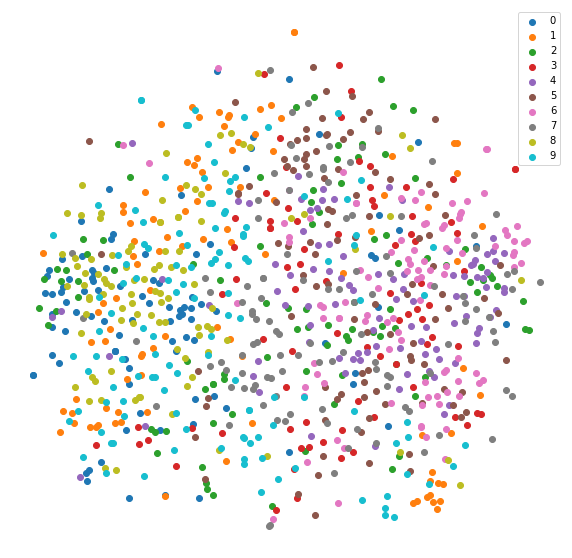

In [49]:
plt.figure(figsize=(10, 10))
plt.axis('off')

for label in range(10):
    plt.scatter(*embeddings[label_batch == label].T, label=str(label))
    
plt.legend()